In [20]:
# Import Libraries
import rawpy as rp
import cv2
import numpy as np
from numpy import asarray
import pandas as pd

import PIL
from PIL import Image
from PIL.ExifTags import TAGS
import exiftool
import notebook

from pathlib import Path 
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Import RAW image of Labsphere Reflectance Standard
# raw = rp.imread('IMG_20240227_113829.dng')
raw = rp.imread('Stacking_Database/IMG_20240227_113829.dng')

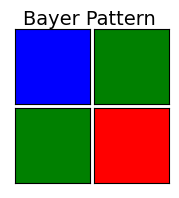

In [22]:
# As we are only interested in the red channel - this snippet determines the camera filter pattern so we can extract 
# only the red channel digital number

bayer = raw.raw_image
bayer_pattern = ''.join(np.array(list((raw.color_desc).decode('ascii')))[raw.raw_pattern].flatten())
color = bayer_pattern.lower()

plt.figure(figsize=(2,2))
gs1 = gridspec.GridSpec(2,2)
gs1.update(wspace=0.05, hspace=0.05)
plt.suptitle('Bayer Pattern', fontsize=14)

for i in range(4):
    ax1 = plt.subplot(gs1[i])
    ax1.set_facecolor(color[i])
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.show()    

In [23]:
# The image above tells us the red channel position.  From here, we use the following conditional to extract red and green 
# channels separately = []
red = []

for i in range(bayer.shape[0]):
    if i % 2 != 0:
        red.append(bayer[i][1::2])

green1, green2 = [],[]

for i in range(bayer.shape[0]):
    if i % 2 == 0:
        green1.append(bayer[i][1::2])
    else:
        green2.append(bayer[i][0::2])

In [24]:
# Post pixel pushing to create new image capable files after extracting
red = np.concatenate(red, axis=0)
red.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green1 = np.concatenate(green1, axis=0)
green1.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green2 = np.concatenate(green2, axis=0)
green2.shape = (int(bayer.shape[0]/2), int(bayer.shape[1]/2))

green = (green1+green2)/2
green = green.astype(int)

### Note - Given the high reflectivity of the Labsphere standard, we are expecting the red channel to saturate, particularly since we are using a red LED to illuminate the sample.  So, we will actually test our uniformity using the green channel which we know will have poorer spectral overlap with the light reflecting off of the sample.

In [25]:
# Selecting the region of interest on the monochrome image
w1, w2 = 400, 400
x1, y1, wx1, wy1 = 790, 550, w1, w2

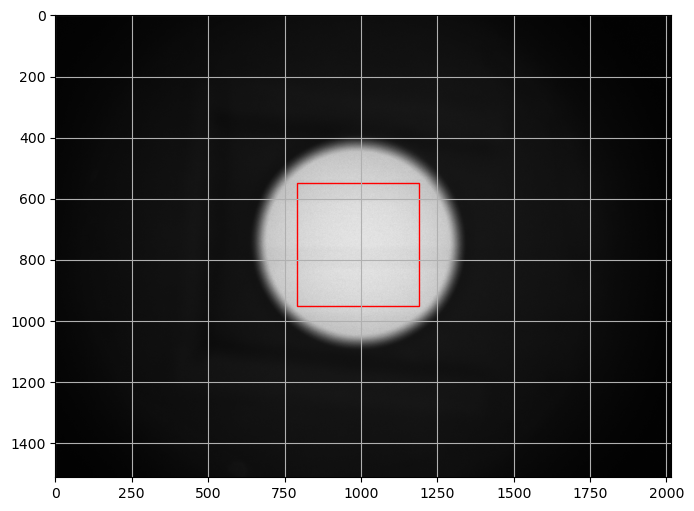

In [26]:
# Plots the monochrome image and highlights the test region
fig, ax = plt.subplots(figsize = (8, 6))
ax.imshow(green,cmap = 'gray')
rect1 = patches.Rectangle((x1, y1), wx1, wy1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
ax.add_patch(rect1)
plt.grid()
plt.show()

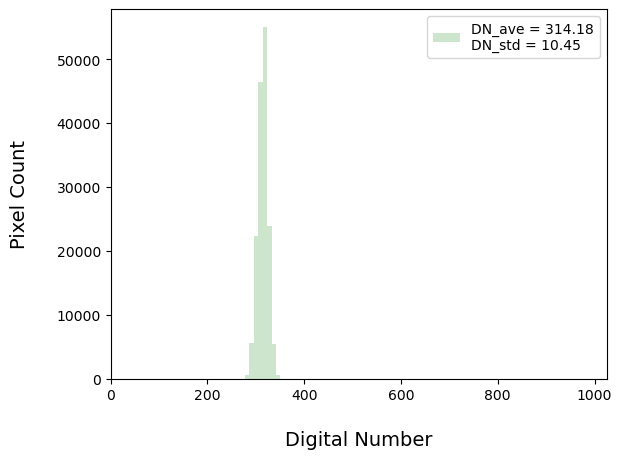

In [27]:
# This is a test to verify that the data is not above the camera's saturation point.  We are targeting a distribution with digital 
# numbers somewhere between 300 to 700.  If greater than 700, consider pulling from the blue channel
def hist(img):
    plt.hist(img.flatten(), bins = 10, color = 'g', alpha = 0.2, label = 'DN_ave = '+str(round(np.average(img), 2))+'\nDN_std = '+str(round(np.std(img), 2)))
    plt.xlabel('\nDigital Number', fontsize = 14)
    plt.ylabel('Pixel Count\n', fontsize = 14)
    plt.xlim(0, 1025)
    plt.legend()
    return plt.show()

hist(green[y1:y1+wy1, x1:x1+wx1])

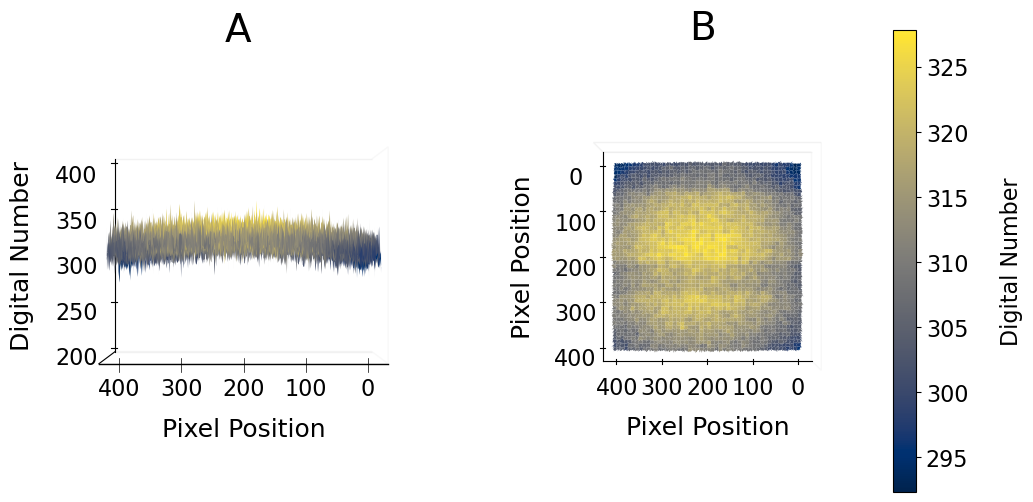

In [28]:
#Plot Uniformity Graphs
im_temp = green[y1:y1+wy1, x1:x1+wx1]
x = np.arange(0, im_temp.shape[1])
y = np.arange(0, im_temp.shape[0])
X,Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))

#Profile
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.tick_params(axis='x', labelsize=16, pad=2)
ax.tick_params(axis='z', labelsize=16, pad=18)
ax.plot_surface(X, Y, im_temp, cmap='cividis')
ax.set_zlim(200, 400)
ax.set_zlabel('Digital Number\n\n\n\n', fontsize=18)
ax.set_xlim(0, 400)
ax.set_xlabel('\n\nPixel Position', fontsize=18)
ax.set_title('A', fontsize=28)
ax.w_xaxis.line.set_lw(1.)
ax.set_xticks([])
ax.set_yticks([])

z_label_plane = 150   
y_label_offset = Y.min()-20  

for x in range(0, 401, 100):
    ax.text(x, y_label_offset, z_label_plane, str(x), fontsize=16, ha='center')
    ax.plot([x, x],
            [y_label_offset, y_label_offset],  
            [z_label_plane+25, z_label_plane+40],  
            color='k', lw=.5)
    
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 90)

#Bird's eye view
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.tick_params(axis='x', labelsize=16, pad=2)
ax.tick_params(axis='y', labelsize=16, pad=10)
p = ax.plot_surface(X, Y, im_temp, cmap='cividis')
ax.set_title('B', pad=38, fontsize=28)
ax.set_xlabel('\n\nPixel Position', fontsize=18)
ax.set_ylabel('Pixel Position\n\n\n', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('\nDigital Number', fontsize=16)
ax.set_zticks([])
ax.w_zaxis.line.set_lw(0.)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(90, 90)

plt.savefig('uniformity.png', bbox_inches='tight', dpi=400)
plt.show()


In [29]:
# Quantify Curvature, Banding, and High-Frequency Noise Quantified

H, W = im_temp.shape
mean_dn = im_temp.mean()

x = np.arange(W)

# CURVATURE (low-frequency illumination gradient)
profile = im_temp.mean(axis=0)          

coeffs = np.polyfit(x, profile, deg=2)
profile_fit = np.polyval(coeffs, x)

p5  = np.percentile(profile_fit, 5)
p95 = np.percentile(profile_fit, 95)
curv_range = p95 - p5
curv_pct   = 100 * curv_range / mean_dn

print(f"Curvature (5–95% of quadratic fit): {curv_range:.2f} DN  ({curv_pct:.2f} % of mean)")

curv_field = np.tile(profile_fit, (H, 1))
im_detrended = im_temp - curv_field


# ROLLING-SHUTTER BANDING (mid-frequency vertical structure)
row_means = im_detrended.mean(axis=1)
rows = np.arange(H)

coeffs_vertical = np.polyfit(rows, row_means, deg=2)
vertical_trend = np.polyval(coeffs_vertical, rows)
row_banding = row_means - vertical_trend

band_range = row_banding.max() - row_banding.min()
band_pct   = 100 * band_range / mean_dn

print(f"Banding (peak-to-trough): {band_range:.2f} DN  ({band_pct:.2f} % of mean)")

# HIGH-FREQUENCY NOISE (residual after removing curvature + banding)
band_field = np.tile(row_banding[:, None], (1, W))
residual   = im_detrended - band_field

noise_std  = residual.std()
noise_pct  = 100 * noise_std / mean_dn

print(f"High-frequency noise (std): {noise_std:.2f} DN  ({noise_pct:.2f} % of mean)")

results = {
    "curvature_pct": curv_pct,
    "banding_pct": band_pct,
    "noise_pct": noise_pct
}

results


Curvature (5–95% of quadratic fit): 12.37 DN  (3.94 % of mean)
Banding (peak-to-trough): 8.86 DN  (2.82 % of mean)
High-frequency noise (std): 9.35 DN  (2.98 % of mean)


{'curvature_pct': 3.9368659130916632,
 'banding_pct': 2.819220353736488,
 'noise_pct': 2.976758790765607}

In [30]:
path = 'Stacking_Database/*.dng'

In [31]:
raw_img = []
for img in glob.glob(path):
    n= rp.imread(img)
    raw_img.append(n)

In [32]:
bayer = []
for i in raw_img:
    bayer.append(i.raw_image)
    
raw_arr = []
for i in bayer:
    raw_arr.append(asarray(i))
    
avg = np.mean(raw_arr, axis=0).astype(int)

In [33]:
red = []

for i in range(avg.shape[0]):
    if i % 2 != 0:
        red.append(avg[i][1::2])

green1, green2 = [],[]

for i in range(avg.shape[0]):
    if i % 2 == 0:
        green1.append(avg[i][1::2])
    else:
        green2.append(avg[i][0::2])

In [34]:
red = np.concatenate(red, axis=0)
red.shape = (int(avg.shape[0]/2), int(avg.shape[1]/2))

green1 = np.concatenate(green1, axis=0)
green1.shape = (int(avg.shape[0]/2), int(avg.shape[1]/2))

green2 = np.concatenate(green2, axis=0)
green2.shape = (int(avg.shape[0]/2), int(avg.shape[1]/2))

green = (green1+green2)/2
green = green.astype(int)

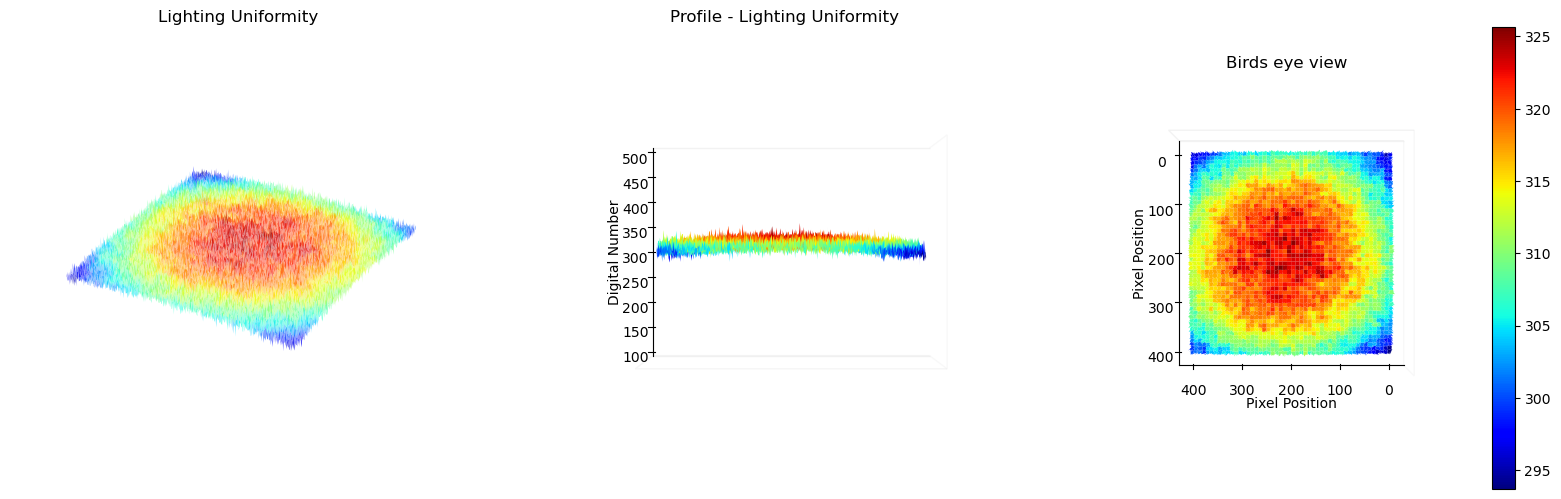

In [35]:
# Selecting the region of interest on the monochrome image
# Selecting the region of interest on the monochrome image
w1, w2 = 400, 400
x, y, wx, wy = 790, 550, w1, w2

im_temp = green[y:y+wy, x:x+wx]
x = np.arange(0, im_temp.shape[1])
y = np.arange(0, im_temp.shape[0])
X,Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, Y, im_temp, cmap='jet', alpha=0.5)
ax.set_zlim(100, 500)
ax.set_zlabel('Digital Number')
ax.set_axis_off()
ax.set_title('Lighting Uniformity')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, Y, im_temp, cmap='jet')
ax.set_zlim(100, 500)
ax.set_zlabel('Digital Number')
ax.set_title('Profile - Lighting Uniformity')
ax.w_xaxis.line.set_lw(0.)
ax.set_xticks([])
ax.w_yaxis.line.set_lw(0.)
ax.set_yticks([])
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 90)

ax = fig.add_subplot(1, 3, 3, projection='3d')
p = ax.plot_surface(X, Y, im_temp, cmap='jet')
ax.set_title('Birds eye view')
ax.set_xlabel('Pixel Position')
ax.set_ylabel('Pixel Position')
fig.colorbar(p, ax=ax)
ax.set_zticks([])
ax.w_zaxis.line.set_lw(0.)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(90, 90)

plt.show()

In [36]:
# Quantify Curvature, Banding, and High-Frequency Noise Quantified

H, W = im_temp.shape
mean_dn = im_temp.mean()

x = np.arange(W)

# CURVATURE (low-frequency illumination gradient)
profile = im_temp.mean(axis=0)          

coeffs = np.polyfit(x, profile, deg=2)
profile_fit = np.polyval(coeffs, x)

p5  = np.percentile(profile_fit, 5)
p95 = np.percentile(profile_fit, 95)
curv_range = p95 - p5
curv_pct   = 100 * curv_range / mean_dn

print(f"Curvature (5–95% of quadratic fit): {curv_range:.2f} DN  ({curv_pct:.2f} % of mean)")

curv_field = np.tile(profile_fit, (H, 1))
im_detrended = im_temp - curv_field


# ROLLING-SHUTTER BANDING (mid-frequency vertical structure)
row_means = im_detrended.mean(axis=1)
rows = np.arange(H)

coeffs_vertical = np.polyfit(rows, row_means, deg=2)
vertical_trend = np.polyval(coeffs_vertical, rows)
row_banding = row_means - vertical_trend

band_range = row_banding.max() - row_banding.min()
band_pct   = 100 * band_range / mean_dn

print(f"Banding (peak-to-trough): {band_range:.2f} DN  ({band_pct:.2f} % of mean)")

# HIGH-FREQUENCY NOISE (residual after removing curvature + banding)
band_field = np.tile(row_banding[:, None], (1, W))
residual   = im_detrended - band_field

noise_std  = residual.std()
noise_pct  = 100 * noise_std / mean_dn

print(f"High-frequency noise (std): {noise_std:.2f} DN  ({noise_pct:.2f} % of mean)")

results = {
    "curvature_pct": curv_pct,
    "banding_pct": band_pct,
    "noise_pct": noise_pct
}

results


Curvature (5–95% of quadratic fit): 12.35 DN  (3.94 % of mean)
Banding (peak-to-trough): 3.30 DN  (1.05 % of mean)
High-frequency noise (std): 8.38 DN  (2.67 % of mean)


{'curvature_pct': 3.9351274982162057,
 'banding_pct': 1.052177405993149,
 'noise_pct': 2.6690084453332727}

Texture residual: mean = -0.000 DN, std = 8.375 DN


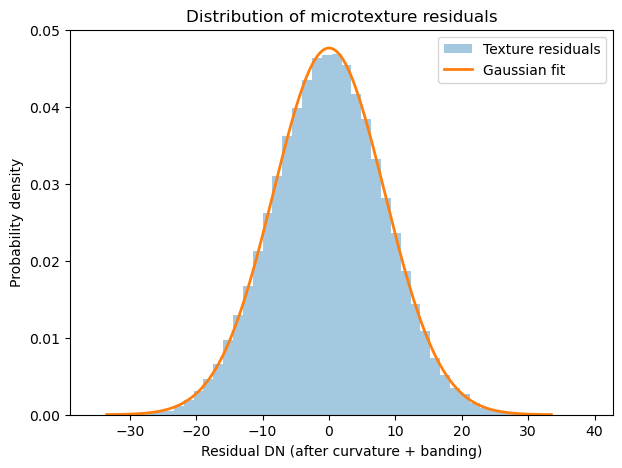

In [37]:
# ============================================================
# Analyze distribution of microtexture (stacked image)
# Assumes:
#   im_temp      = stacked ROI (H x W)
#   curv_field   = 2D curvature field (H x W)
#   row_banding  = 1D banding signal per row (length H)
# ============================================================

H, W = im_temp.shape

# Rebuild banding field for the stacked image
band_field = np.tile(row_banding[:, None], (1, W))

# Remove curvature and banding from the stacked ROI
texture_field = im_temp - curv_field - band_field

# Subtract global mean so we look at variations around zero
texture_residual = texture_field - texture_field.mean()

# Flatten to 1D for histogram analysis
samples = texture_residual.flatten()

print(f"Texture residual: mean = {samples.mean():.3f} DN, std = {samples.std():.3f} DN")

# ------------------------------------------------------------
# Histogram + Gaussian fit
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

mu = samples.mean()
sigma = samples.std()

fig, ax = plt.subplots(figsize=(7, 5))

# Histogram of residuals
ax.hist(samples, bins=50, density=True, alpha=0.4, label='Texture residuals')

# Gaussian fit curve
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
gauss = (1.0 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5 * ((xs - mu)/sigma)**2)
ax.plot(xs, gauss, linewidth=2, label='Gaussian fit')

ax.set_xlabel('Residual DN (after curvature + banding)')
ax.set_ylabel('Probability density')
ax.set_title('Distribution of microtexture residuals')
ax.legend()
plt.show()
